In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'

config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])

dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor
    
def print_to_debug_observation():    
    observation_components = ['image','spectrum', 'trajectory','timestep']
    for comp, this, prev in zip(observation_components,
                          env.unflatten_observation(prev_state),
                          env.unflatten_observation(state)):
        print('--------',comp,'-------:')
        for fn_name, fn in {'var': np.var, 'mean': np.mean, 'max':np.max, 'min': np.min}.items():
            print(fn_name, fn(this),fn(prev))

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

env = RetinaEnv(config, image_generator=dataset)

if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound

# You might want to adjust the hyperparameters
actor_lr = 0.001
critic_lr = 0.002
gamma = 0.99
tau = 0.005

buffer_capacity = 1000
batch_size = 64



# Create actor and critic networks
actor_model = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
critic_model = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Create target actor and critic networks
target_actor = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
target_critic = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Experience replay buffer
buffer = Buffer(buffer_capacity, config.batch_size, num_states=num_states, num_actions=num_actions,
                state_reshape_fn=env.unflatten_observation)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


-------- image -------:
var 0.038198803 0.041350514
mean 0.019719603 0.019610366
max 1.8575649 1.8237797
min -1.771566 -1.825956
-------- spectrum -------:
var 0.0 0.0005607458
mean 0.0 0.083333336
max 0.0 0.17080158
min 0.0 0.03691355
-------- trajectory -------:
var 9.170204 10.372978
mean -0.098594815 -0.07963642
max 11.071517 11.071517
min -9.766358 -10.7870865
-------- timestep -------:
var 0.0 0.0
mean 16.0 17.0
max 16.0 17.0
min 16.0 17.0
-------- image -------:
var 0.041350514 0.0443974
mean 0.019610366 0.019385306
max 1.8237797 1.8593502
min -1.825956 -1.9888109
-------- spectrum -------:
var 0.0005607458 0.000558592
mean 0.083333336 0.083333336
max 0.17080158 0.17424864
min 0.03691355 0.038210906
-------- trajectory -------:
var 10.372978 11.572548
mean -0.07963642 -0.07854453
max 11.071517 11.071517
min -10.7870865 -11.316818
-------- timestep -------:
var 0.0 0.0
mean 17.0 18.0
max 17.0 18.0
min 17.0 18.0
-------- image -------:
var 0.0443974 0.047900535
mean 0.019385306 0.

-------- image -------:
var 0.040374838 0.041598417
mean 0.020518042 0.020418808
max 1.8669425 1.9006662
min -1.9027067 -1.8714216
-------- spectrum -------:
var 0.0004818551 0.00048245428
mean 0.083333336 0.083333336
max 0.16815142 0.16830336
min 0.038216393 0.038153168
-------- trajectory -------:
var 28.489063 29.870768
mean 0.08484933 0.086949825
max 13.058063 13.5319195
min -14.525309 -14.525309
-------- timestep -------:
var 0.0 0.0
mean 33.0 34.0
max 33.0 34.0
min 33.0 34.0
-------- image -------:
var 0.041598417 0.042697575
mean 0.020418808 0.020305425
max 1.9006662 1.8773019
min -1.8714216 -1.7985005
-------- spectrum -------:
var 0.00048245428 0.00048171252
mean 0.083333336 0.083333336
max 0.16830336 0.16829303
min 0.038153168 0.038119275
-------- trajectory -------:
var 29.870768 31.348755
mean 0.086949825 0.078526914
max 13.5319195 13.695319
min -14.525309 -15.191215
-------- timestep -------:
var 0.0 0.0
mean 34.0 35.0
max 34.0 35.0
min 34.0 35.0
-------- image -------:
va

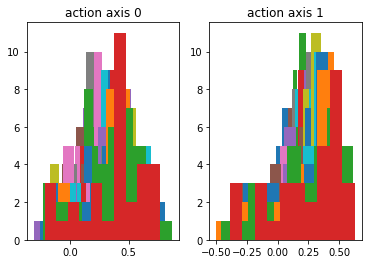

In [2]:
# Training loop
reward_records = []
epsilon_records = []
episodes = 1000
ep = 0 
prev_state = env.reset()
episodic_reward = 0
epsilon = epsilon_scheduler(ep)

while True:
    # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

    deterministic_action = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)
    random_action = -2+4*np.random.uniform(size=(config.batch_size,2))

    if env.warmup_done:
        action = epsilon*random_action + (1-epsilon)*deterministic_action
    else:
        action = random_action

    # Recieve state and reward from environment
    state, reward, done, info = env.step(action)

    if env.warmup_done:
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        print_to_debug_observation()

#             buffer.learn(actor_model, target_actor, critic_model, target_critic, actor_optimizer, critic_optimizer, gamma, tau)
#             update_target(target_actor.variables, actor_model.variables, tau)
#             update_target(target_critic.variables, critic_model.variables, tau)
    # End this episode when `done` is True
        plt.subplot(1,2,1)
        _= plt.hist(deterministic_action.numpy()[:,0])
        plt.title('action axis 0')

        plt.subplot(1,2,2)
        _= plt.hist(deterministic_action.numpy()[:,1])
        plt.title('action axis 1')
    if done:
        break

    #prev_state = state avoid assingment by reference:
    prev_state = np.copy(state)
#         print('debug action: ', action[0])

print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
reward_records.append(episodic_reward.numpy().mean())
epsilon_records.append(epsilon)

In [3]:
deterministic_action

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[ 0.6161823 ,  0.43939912],
       [ 0.44471085,  0.21216142],
       [-0.01927073, -0.39033425],
       [ 0.05043278, -0.09327459],
       [ 0.41558155,  0.5656601 ],
       [ 0.3791321 ,  0.40349442],
       [ 0.23623061,  0.6253798 ],
       [ 0.6656864 ,  0.47639644],
       [-0.21890986, -0.32319057],
       [ 0.4176027 ,  0.08619244],
       [ 0.24616194,  0.218191  ],
       [ 0.38377786,  0.19169824],
       [ 0.42258757,  0.40716225],
       [ 0.5835756 ,  0.3853652 ],
       [ 0.4583869 ,  0.49935418],
       [-0.18098873, -0.15130726],
       [ 0.46568182,  0.39759904],
       [ 0.7691665 ,  0.4467408 ],
       [ 0.51299715,  0.559018  ],
       [-0.03379389, -0.18235385],
       [ 0.43267035,  0.42294976],
       [ 0.7121987 ,  0.47152954],
       [ 0.76452184,  0.4940217 ],
       [-0.21406907, -0.30561942],
       [ 0.42521268,  0.0996483 ],
       [ 0.35330337,  0.41234577],
       [ 0.271609  ,  0.066028  ],
      

In [4]:
env.unflatten_observation(state)[3]

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.]], dtype=float32)>

In [5]:
state, reward, done, info = env.step(action)

In [6]:
policy(env.unflatten_observation(state), actor_model, lower_bound, upper_bound)

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[ 0.5781832 ,  0.5246262 ],
       [ 0.44843125,  0.27862436],
       [-0.09099596, -0.2022509 ],
       [-0.01955959, -0.1463865 ],
       [ 0.39291066,  0.49446604],
       [ 0.38634592,  0.52521276],
       [ 0.28196642,  0.63780683],
       [ 0.66249406,  0.535202  ],
       [-0.17955598, -0.30785924],
       [ 0.18314834, -0.03604948],
       [ 0.00510889,  0.2269024 ],
       [ 0.3097368 ,  0.03028463],
       [ 0.450569  ,  0.47416216],
       [ 0.6750397 ,  0.31458822],
       [ 0.45075104,  0.50909716],
       [-0.21640067, -0.18546028],
       [ 0.53341174,  0.35753384],
       [ 0.69668746,  0.473656  ],
       [ 0.41351283,  0.38637918],
       [ 0.10820051, -0.17191407],
       [ 0.52434963,  0.39789236],
       [ 0.646593  ,  0.49081215],
       [ 0.71776634,  0.38336468],
       [-0.11959614, -0.34353647],
       [ 0.5400825 ,  0.06792139],
       [ 0.3286143 ,  0.4555419 ],
       [ 0.29785657,  0.05267247],
      

In [7]:
observation_components = ['image','spectrum', 'trajectory','timestep']
for comp, this, prev in zip(observation_components,
                      env.unflatten_observation(prev_state),
                      env.unflatten_observation(state)):
    print('--------',comp,'-------:')
    for fn_name, fn in {'var': np.var, 'mean': np.mean, 'max':np.max, 'min': np.min}.items():
        print(fn_name, fn(this),fn(prev))

-------- image -------:
var 0.04064393 0.039299827
mean 0.018212447 0.018281164
max 1.6961355 1.8747169
min -1.9083191 -1.7763025
-------- spectrum -------:
var 0.00047768548 0.0004780687
mean 0.083333336 0.083333336
max 0.16697194 0.16650192
min 0.03518328 0.035063397
-------- trajectory -------:
var 49.122578 51.441963
mean 0.18613258 0.17746891
max 15.650115 16.843008
min -20.587603 -20.587603
-------- timestep -------:
var 0.0 0.0
mean 49.0 51.0
max 49.0 51.0
min 49.0 51.0
